#**Pattern Recognition and Machine Learning (CSN2050) - 2022**
##**Major Project**

###**Stroke Prediction using Machine Learning**

### Dataset link: 
https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset


In [2]:
# To Disable Convergence Warnings (For Custom Training)
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import reciprocal, uniform
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split

In [4]:
# Encoder for encoding categorical values 
from sklearn.preprocessing import LabelEncoder

In [5]:
# Scalers for scaling the dataset
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.preprocessing import StandardScaler as SS

In [6]:
# Metrics for performance evaluation
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import f1_score as f1score
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

In [7]:
# Importing the Classifiers
from sklearn.ensemble import RandomForestClassifier as RFC 
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.svm import LinearSVC as SVC
from xgboost import XGBClassifier as XGBC
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.neighbors import KNeighborsClassifier as KNC

In [8]:
# RandomizedSearchCV to find optimal hyperparameters
from sklearn.model_selection import RandomizedSearchCV

##**Preprocessing the Dataset**

In [9]:
# Reading the dataframe
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")

In [ ]:
# Printing the top rows of the dataframe
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
# An overall description of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [10]:
# Encoding the columns with string values using Label Encoder to convert them into numerical
# values for easy computation.

label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['ever_married'] = label_encoder.fit_transform(df['ever_married'])
df['work_type'] = label_encoder.fit_transform(df['work_type'])
df['Residence_type'] = label_encoder.fit_transform(df['Residence_type'])
df['smoking_status'] = label_encoder.fit_transform(df['smoking_status'])

In [ ]:
# Dimensions of dataset
df.shape

(5110, 12)

In [ ]:
# Observing Null values
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [11]:
# Replacing the Null values by the mean of their respective columns
df.bmi.fillna(df.bmi.mean(),inplace = True)

In [ ]:
# Distribution of data points across different attributes
cat_features = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status","hypertension"]
for i in cat_features:
  print(i,":")
  for j in np.unique(np.array(df[i])):
    print(j,":",list(df[i]).count(j))

gender :
0 : 2994
1 : 2115
2 : 1
ever_married :
0 : 1757
1 : 3353
work_type :
0 : 657
1 : 22
2 : 2925
3 : 819
4 : 687
Residence_type :
0 : 2514
1 : 2596
smoking_status :
0 : 1544
1 : 885
2 : 1892
3 : 789
hypertension :
0 : 4612
1 : 498


In [ ]:
df.drop(df[df['gender'] == 2].index, axis = 0, inplace=True)

## **Visualizing the distribution of Data**

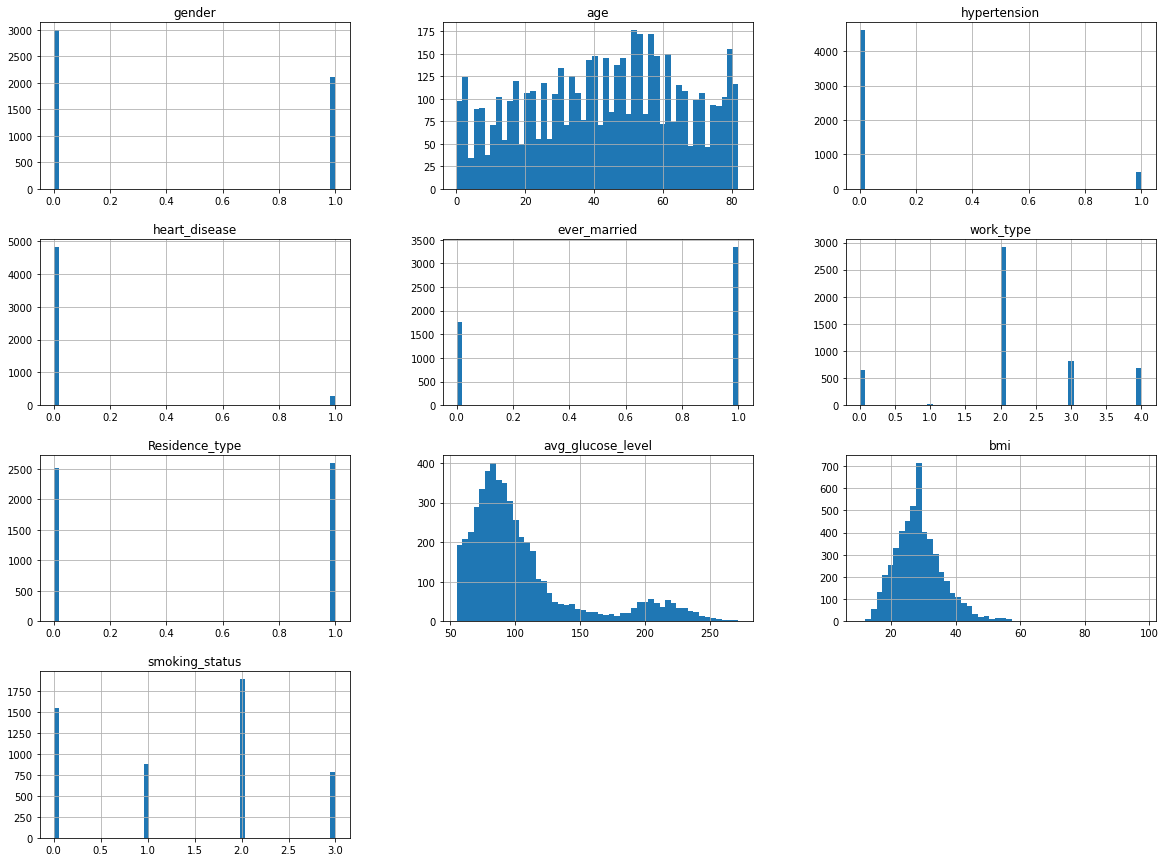

In [ ]:
# Histograms showing distribution across the features
df.iloc[:,1:-1].hist(bins=50, figsize=(20,15))
plt.show()

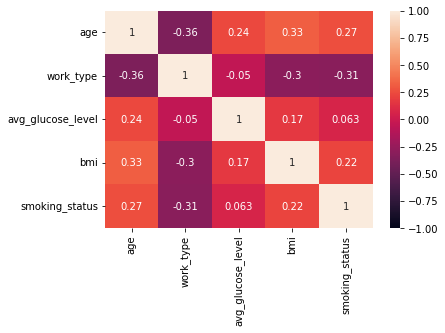

In [ ]:
# Heatmap to visualize the correlation between the attributes 
sns.heatmap(df[["age", 'work_type', 'avg_glucose_level', 'bmi', 'smoking_status']].corr(), vmin=-1, vmax=1, annot=True)

In [13]:
# X and y data
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
del X['id']

## **Applying SMOTE to increase the samples containing 1 as predicted values**

This is done as the given dataset is highly skewed towards output label 0. This leads to the model being biased towards predictions with label 0, and it classifies predictions with output 1 as also 0, which is type - 2 error, and is highly critical here (Patients vulnerable to stroke are classified as the opposite which could prove to be deadly). Hence, we increase the number of samples with output value 1, so at the cost of accuracy we decrease the type - 2 error, which is a safer option in the world of diagnosis.

In [14]:
# Applying SMOTE to increase the number of samples of output class y = 1
# to ensure uniform distribution of data points so that model does not
# lead to more type - 2 Error which is critical here
smote = SMOTE()
counter = Counter(y)
print('Original dataset shape', counter)

# fit predictor and target variable
X_after_smote, y_after_smote = smote.fit_resample(X, y)

counter = Counter(y_after_smote)
print('Resample dataset shape', counter)

Original dataset shape Counter({0: 4861, 1: 249})
Resample dataset shape Counter({1: 4861, 0: 4861})


Splitting the dataset ito train, validation and test data

In [15]:
# Splitting the data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X_after_smote, y_after_smote, stratify = y_after_smote, train_size=0.8, random_state=42)

In [16]:
# Using Min-Max Scaler to scale the data
scaler = MMS()
X_train['bmi'] = scaler.fit_transform(pd.DataFrame(X_train['bmi']))
X_train['avg_glucose_level'] = scaler.fit_transform(pd.DataFrame(X_train['avg_glucose_level']))
X_train['age'] = scaler.fit_transform(pd.DataFrame(X_train['age']))


In [17]:
# Splitting the data into train and validation splits
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, stratify = y_train, train_size = 0.8, random_state = 42)

In [18]:
df1 = df.copy()

In [ ]:
# Function to create stacked barcharts for better visualization of continuous features
def stacked_barchart(column):
  df_breakdown = df1.groupby([column,'stroke'])['age'].count()
  df_tot = df1.groupby([column])['age'].count()
  df_pct = (df_breakdown/df_tot)*100
  df_pct = df_pct.unstack()
  return df_pct.plot.bar(stacked=True,figsize=(5,5),width=0.5) 

# discretizing the continuous features
df1['age'] = pd.cut(df1['age'],np.arange(0,85,5))
df1['bmi'] = pd.cut(df1['bmi'],np.arange(10,100,5))
df1['avg_glucose_level'] = pd.cut(df1['avg_glucose_level'],np.arange(55,275,10))

Visualization of the distribution of features using stacked barcharts

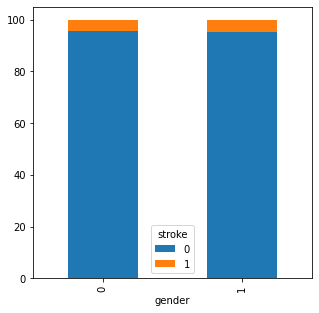

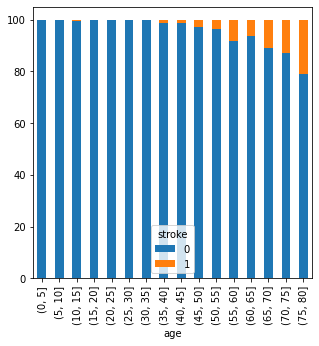

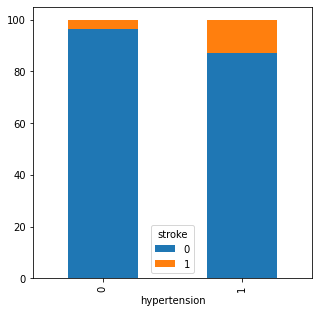

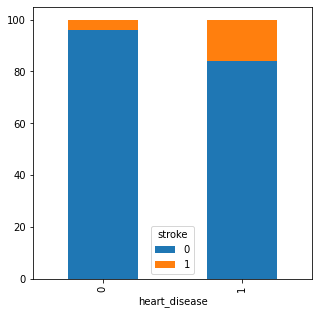

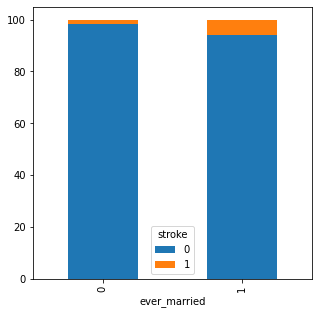

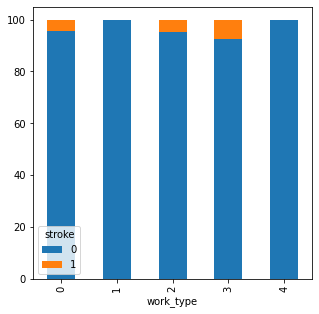

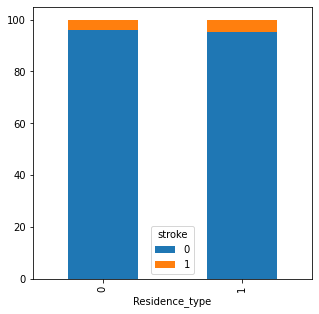

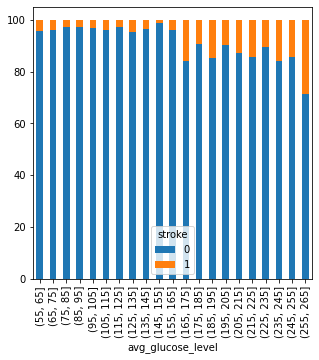

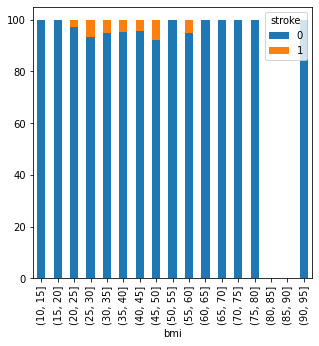

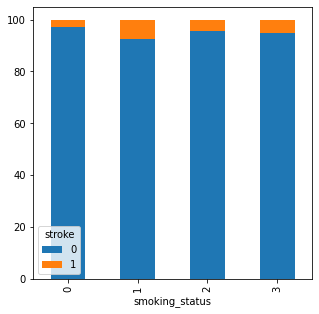

In [ ]:
# Stacked bar charts for visualization
for i in df1.columns[1:-1]:
  stacked_barchart(i)

In [ ]:
# Function to calculate type-2 error (an important evaluation metrics here)
def type2_error(cm):
  return (cm[0][1]/(cm[0][1] + cm[1][1]))

# **Manual Hyperparameter tuning**

Here, we apply manual tuning of hyperparameters and check their performance over the validation dataset using the evaluation metrics as accuracy and type - 2 error.

### **1. Random Forest Classifier**

In [ ]:
model1 = RFC()
model1.fit(X_train,y_train)
y_pred1 = model1.predict(X_test)
accuracy(y_test,y_pred1),type2_error(cm(y_test,y_pred1))

(0.8984910836762688, 0.10096153846153846)

In [ ]:
for i in range(10):
  model1 = RFC(n_estimators = 100 + 50*i,max_depth = 2+i,min_samples_split = 2+ 2*i,max_features = 'auto',min_samples_leaf = 2+2*i)
  model1.fit(X_train,y_train)
  y_pred1 = model1.predict(X_validation)
  print("i = ",i)
  print(accuracy(y_validation,y_pred1),type2_error(cm(y_validation,y_pred1)))


i =  0
0.7766895200783546 0.28679245283018867
i =  1
0.7982370225269344 0.2611764705882353
i =  2
0.8080313418217434 0.24940239043824702
i =  3
0.8256611165523996 0.22768222768222768
i =  4
0.8310479921645446 0.21500843170320405
i =  5
0.8501469147894222 0.19313304721030042
i =  6
0.8530852105778648 0.18679409209383144
i =  7
0.8643486777668952 0.17425569176882663
i =  8
0.8653281096963761 0.16991150442477876
i =  9
0.8658178256611165 0.16976127320954906


In [ ]:
min_samples_split = [2,3,5,7,10,15,20]
min_samples_leaf = [2,3,5,7,10,15,20]
for i in min_samples_leaf:
  for j in min_samples_split :
    model1 = RFC(n_estimators = 500,max_depth = 10,min_samples_split = j,max_features = 'auto',min_samples_leaf = i)
    model1.fit(X_train,y_train)
    y_pred1 = model1.predict(X_validation)
    print("i = ",i,"j = ",j)
    print(accuracy(y_validation,y_pred1),type2_error(cm(y_validation,y_pred1)))

i =  2 j =  2
0.8917727717923605 0.1447602131438721
i =  2 j =  3
0.8907933398628796 0.1443850267379679
i =  2 j =  5
0.89128305582762 0.1448888888888889
i =  2 j =  7
0.8893241919686582 0.14666666666666667
i =  2 j =  10
0.8868756121449559 0.149822695035461
i =  2 j =  15
0.8849167482859941 0.15221238938053097
i =  2 j =  20
0.8829578844270323 0.15151515151515152
i =  3 j =  2
0.8907933398628796 0.14690265486725665
i =  3 j =  3
0.8893241919686582 0.1460373998219056
i =  3 j =  5
0.8878550440744368 0.14893617021276595
i =  3 j =  7
0.8888344760039177 0.14742451154529307
i =  3 j =  10
0.8898139079333987 0.14590747330960854
i =  3 j =  15
0.8844270323212536 0.15296198054818744
i =  3 j =  20
0.8844270323212536 0.1511111111111111
i =  5 j =  2
0.8839373163565132 0.1524822695035461
i =  5 j =  3
0.8849167482859941 0.15159574468085107
i =  5 j =  5
0.8824681684622919 0.15288888888888888
i =  5 j =  7
0.8824681684622919 0.15411868910540302
i =  5 j =  10
0.8854064642507345 0.14897413024085

In [ ]:
n_estimators = [200,250,300,350,400,450,500,550,600,650,700]
max_depth = [2,3,5,7,10]
for i in n_estimators:
  for j in max_depth :
    model1 = RFC(n_estimators = i,max_depth = j,min_samples_split = 2,max_features = 'auto',min_samples_leaf = 2)
    model1.fit(X_train,y_train)
    y_pred1 = model1.predict(X_validation)
    print("i = ",i,"j = ",j)
    print(accuracy(y_validation,y_pred1),type2_error(cm(y_validation,y_pred1)))

i =  200 j =  2
0.7727717923604309 0.2907588279489106
i =  200 j =  3
0.7908912830558276 0.26976744186046514
i =  200 j =  5
0.8197845249755142 0.23346938775510204
i =  200 j =  7
0.8530852105778648 0.19108826049700087
i =  200 j =  10
0.8937316356513222 0.14298401420959148
i =  250 j =  2
0.7796278158667973 0.2842025699168556
i =  250 j =  3
0.7894221351616063 0.271461716937355
i =  250 j =  5
0.8232125367286973 0.23083197389885807
i =  250 j =  7
0.8555337904015671 0.18760757314974183
i =  250 j =  10
0.8907933398628796 0.14501779359430605
i =  300 j =  2
0.7757100881488737 0.2891385767790262
i =  300 j =  3
0.7918707149853085 0.2682737169517885
i =  300 j =  5
0.821743388834476 0.23183673469387756
i =  300 j =  7
0.856513222331048 0.18835616438356165
i =  300 j =  10
0.8903036238981391 0.1470327723649247
i =  350 j =  2
0.7757100881488737 0.2888222055513878
i =  350 j =  3
0.7908912830558276 0.2704791344667697
i =  350 j =  5
0.8256611165523996 0.22633744855967078
i =  350 j =  7
0.

In [ ]:
model1 = RFC(n_estimators = 600,max_depth = 10,min_samples_split = 2,max_features = 'auto',min_samples_leaf = 2)
model1.fit(X_train,y_train)
y_pred1 = model1.predict_proba(X_test)
y_pred11 = model1.predict(X_test)
#  print("i = ",i,"j = ",j)
print(roc_auc_score(y_test,y_pred1[:,1]),type2_error(cm(y_test,y_pred11)))

0.9524490959485625 0.15044814340588988


### **2. Support Vector Classifier**

In [ ]:
model2 = SVC()
model2.fit(X_train,y_train)
y_pred2 = model2.predict(X_test)
accuracy(y_test,y_pred2),type2_error(cm(y_test,y_pred2))

(0.8113854595336076, 0.21192893401015228)

In [ ]:
C = [0.1, 1, 10, 100, 1000]
tol=[0.00001, 0.0001,0.001,0.01,0.1,1,10]
max_iter =[100,200,300,500]
opt = 1
x=0
y=0
z=0
for i in C:
  for j in tol :
    for k in max_iter :
      model1 = SVC(C=i,tol=j,max_iter=k)
      model1.fit(X_train,y_train)
      y_pred1 = model1.predict(X_validation)
      # print("i = ",i,"j = ",j,"k = ",k)
      # print(type2_error(cm(y_validation,y_pred1)))
      if(type2_error(cm(y_validation,y_pred1)) < opt):
        opt = type2_error(cm(y_validation,y_pred1))
        x=i
        y=j
        z=k

print(x,y,z)
print(opt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


1000 0.01 200
0.08595988538681948


In [ ]:
model2 = SVC(C=1000,tol=0.01,max_iter=200)
model2.fit(X_train,y_train)
# y_pred2 = model2.predict_proba(X_test)
y_pred22 = model2.predict(X_test)
print(type2_error(cm(y_test,y_pred22)))

0.0851528384279476


### **3. XGBoost Classifier**

In [ ]:
model3 = XGBC()
model3.fit(X_train,y_train)
y_pred3 = model3.predict(X_test)
accuracy(y_test,y_pred3),type2_error(cm(y_test,y_pred3))


(0.8439643347050755, 0.17790622992935132)

In [ ]:
for i in range(1,10):
  model1 = XGBC(n_estimators = 100 + 50*i,eta = 0.1*i,subsample = 0.1*i,max_depth = 2+i,min_samples_split = 2+ 2*i,min_samples_leaf = 2+2*i)
  model1.fit(X_train,y_train)
  y_pred1 = model1.predict(X_validation)
  print("i = ",i)
  print(accuracy(y_validation,y_pred1),type2_error(cm(y_validation,y_pred1)))


i =  1
0.8638589618021547 0.15247895229186156
i =  2
0.8907933398628796 0.129182156133829
i =  3
0.915279138099902 0.10740740740740741
i =  4
0.9265426052889324 0.09563602599814298
i =  5
0.9353574926542605 0.09107635694572216
i =  6
0.93486777668952 0.08426966292134831
i =  7
0.9417238001958864 0.07612781954887218
i =  8
0.9407443682664055 0.07627118644067797
i =  9
0.9382957884427032 0.0813844714686623


In [ ]:
min_samples_split = [2,3,5,7,10,15,20]
min_samples_leaf = [2,3,5,7,10,15,20]
for i in min_samples_leaf:
  for j in min_samples_split :
    model1 = XGBC(n_estimators = 450,eta = 0.7,max_depth = 9,subsample=0.7,min_samples_split = j,min_samples_leaf = i)
    model1.fit(X_train,y_train)
    y_pred1 = model1.predict(X_validation)
    print("i = ",i,"j = ",j)
    print(accuracy(y_validation,y_pred1),type2_error(cm(y_validation,y_pred1)))

In [ ]:
n_estimators = [300,350,400,450,500,550,600,650,700]
max_depth = [2,3,5,7,10,15,20]
for i in max_depth:
  for j in n_estimators :
    model1 = XGBC(n_estimators = j,eta = 0.7,max_depth = i,subsample=0.7)
    model1.fit(X_train,y_train)
    y_pred1 = model1.predict(X_validation)
    print("i = ",i,"j = ",j)
    print(accuracy(y_validation,y_pred1),type2_error(cm(y_validation,y_pred1)))

i =  2 j =  300
0.8790401567091087 0.14495412844036698
i =  2 j =  350
0.8839373163565132 0.14036697247706423
i =  2 j =  400
0.8878550440744368 0.1326530612244898
i =  2 j =  450
0.8893241919686582 0.13023255813953488
i =  2 j =  500
0.8952007835455436 0.12465116279069767
i =  2 j =  550
0.8952007835455436 0.12742382271468145
i =  2 j =  600
0.8971596474045054 0.12418906394810009
i =  2 j =  650
0.9000979431929481 0.12
i =  2 j =  700
0.9040156709108716 0.11556383970177074
i =  3 j =  300
0.9040156709108716 0.11770157553290084
i =  3 j =  350
0.905484818805093 0.11595547309833024
i =  3 j =  400
0.9128305582761999 0.10717614165890028
i =  3 j =  450
0.9162585700293829 0.1042830540037244
i =  3 j =  500
0.9182174338883448 0.10242085661080075
i =  3 j =  550
0.9191968658178257 0.09774436090225563
i =  3 j =  600
0.921645445641528 0.09878844361602983
i =  3 j =  650
0.9270323212536729 0.09099437148217636
i =  3 j =  700
0.9255631733594515 0.09278350515463918
i =  5 j =  300
0.92948090107

In [ ]:
subsample = [0.4,0.5,0.6,0.7,0.8,0.9,1]
eta = [0.01,0.1,0.2,0.5,0.7,0.8,0.9,1]
for i in eta:
  for j in subsample :
    model1 = XGBC(n_estimators = 700,eta = i,max_depth = 7,subsample=j)
    model1.fit(X_train,y_train)
    y_pred1 = model1.predict(X_validation)
    print("i = ",i,"j = ",j)
    print(accuracy(y_validation,y_pred1),type2_error(cm(y_validation,y_pred1)))

i =  0.01 j =  0.4
0.9343780607247796 0.08278457196613359
i =  0.01 j =  0.5
0.9338883447600391 0.08675373134328358
i =  0.01 j =  0.6
0.9387855044074437 0.08052434456928839
i =  0.01 j =  0.7
0.9431929480901078 0.07431796801505174
i =  0.01 j =  0.8
0.9417238001958864 0.07532956685499058
i =  0.01 j =  0.9
0.9422135161606269 0.0728476821192053
i =  0.01 j =  1
0.9427032321253673 0.07196969696969698
i =  0.1 j =  0.4
0.9343780607247796 0.08278457196613359
i =  0.1 j =  0.5
0.9338883447600391 0.08675373134328358
i =  0.1 j =  0.6
0.9387855044074437 0.08052434456928839
i =  0.1 j =  0.7
0.9431929480901078 0.07431796801505174
i =  0.1 j =  0.8
0.9417238001958864 0.07532956685499058
i =  0.1 j =  0.9
0.9422135161606269 0.0728476821192053
i =  0.1 j =  1
0.9427032321253673 0.07196969696969698
i =  0.2 j =  0.4
0.9343780607247796 0.08278457196613359
i =  0.2 j =  0.5
0.9338883447600391 0.08675373134328358
i =  0.2 j =  0.6
0.9387855044074437 0.08052434456928839
i =  0.2 j =  0.7
0.9431929480

In [ ]:
model3 = XGBC(n_estimators = 700,eta = 0.08 ,max_depth = 7)
model3.fit(X_train,y_train)
y_pred3 = model3.predict_proba(X_test)
y_pred33 = model3.predict(X_test)
# y_pred1 = pd.DataFrame(y_pred1)
    # print("i = ",i,"j = ",j)
print(roc_auc_score(y_test,y_pred3[:,1]),type2_error(cm(y_test,y_pred33)))

0.96053089618603 0.14702233250620347


### **4. Multilayer Perceptron Classifier**

In [ ]:
model4 = MLPC()
model4.fit(X_train,y_train)
y_pred4 = model4.predict(X_test)
type2_error(cm(y_test,y_pred4))

0.15915300546448088

In [ ]:
hidden_layers = [(64,32,16),(128,64,32,16),(32,32,32),(64,32),(128,32)]
# max_iter = ['lbfgs','adam','sgd']
max_iter = [100,200,300,400,500,600,700]
# learning_rate = [0.001,0.01,0.1,0.2,0.5,0.6,0.7,0.9]
for i in hidden_layers:
  for j in max_iter :
    model4 = MLPC(hidden_layer_sizes = i,max_iter=j)
    model4.fit(X_train,y_train)
    y_pred4 = model4.predict(X_validation)
    print("i = ",i,"j = ",j)
    print(type2_error(cm(y_validation,y_pred4)))


i =  (64, 32, 16) j =  100
0.19143117593436645
i =  (64, 32, 16) j =  200
0.18995433789954339
i =  (64, 32, 16) j =  300
0.15690168818272096
i =  (64, 32, 16) j =  400
0.19384057971014493
i =  (64, 32, 16) j =  500
0.17033492822966506
i =  (64, 32, 16) j =  600
0.14911366006256518
i =  (64, 32, 16) j =  700
0.16388616290480865
i =  (128, 64, 32, 16) j =  100
0.14822546972860126
i =  (128, 64, 32, 16) j =  200
0.17520969245107176
i =  (128, 64, 32, 16) j =  300
0.20202874049027894
i =  (128, 64, 32, 16) j =  400
0.16801437556154536
i =  (128, 64, 32, 16) j =  500
0.1638163816381638
i =  (128, 64, 32, 16) j =  600
0.18907198612315698
i =  (128, 64, 32, 16) j =  700
0.14940421631530706
i =  (32, 32, 32) j =  100
0.18005808325266215
i =  (32, 32, 32) j =  200
0.18855534709193245
i =  (32, 32, 32) j =  300
0.160481444332999
i =  (32, 32, 32) j =  400
0.15612648221343872
i =  (32, 32, 32) j =  500
0.2069271758436945
i =  (32, 32, 32) j =  600
0.17786187322611163
i =  (32, 32, 32) j =  700
0.

In [ ]:
# hidden_layers = [(64,32,16),(128,64,32,16),(32,32,32),(64,32),(128,32)]
solver = ['lbfgs','adam','sgd']
# max_iter = [100,200,300,400,500,600,700]
learning_rate = [0.001,0.01,0.1,0.2]
for i in solver:
  for j in learning_rate :
    model4 = MLPC(hidden_layer_sizes = (64, 32, 16),max_iter=600,solver=i,learning_rate_init=j)
    model4.fit(X_train,y_train)
    y_pred4 = model4.predict(X_validation)
    print("i = ",i,"j = ",j)
    print(type2_error(cm(y_validation,y_pred4)))


In [ ]:
# hidden_layers = [(64,32,16),(128,64,32,16),(32,32,32),(64,32),(128,32)]
# solver = ['lbfgs','adam','sgd']
# max_iter = [100,200,300,400,500,600,700]
# learning_rate = [0.001,0.01,0.1,0.2]
activation = ['relu','tanh','logistic']
for i in activation:
  # for j in learning_rate :
  model4 = MLPC(hidden_layer_sizes = (128,64, 32, 16),max_iter=600,solver='adam',learning_rate_init=0.01,activation = i)
  model4.fit(X_train,y_train)
  y_pred4 = model4.predict(X_validation)
  print("i = ",i)
  print(type2_error(cm(y_validation,y_pred4)))


i =  relu
0.1503690036900369
i =  tanh
0.14244741873804972
i =  logistic
0.17290552584670232


In [ ]:
model4 = MLPC(hidden_layer_sizes = (128,64, 32, 16),max_iter=600,solver='adam',learning_rate_init=0.01,activation = 'tanh')
model4.fit(X_train,y_train)
y_pred4 = model4.predict_proba(X_test)
y_pred44 = model4.predict(X_test)
print(roc_auc_score(y_test,y_pred4[:,1]),type2_error(cm(y_test,y_pred44)))

0.9422828686533407 0.15958102279728897


### **5. KNN Classifier**

In [ ]:
acc_list=[]
best_params=[]

In [ ]:
n_neighbors = [5,7,9,11,13,15]
weights = ['uniform','distance']
metric = ['minkowski','euclidean','manhattan']


In [ ]:
for i in n_neighbors:
  for j in weights:
    for k in metric:
      params_list=[]
      knn_classifier = KNC(weights =  j, n_neighbors = i, metric = k) # Hyperparameters 
      knn_classifier.fit(X_train, y_train)                      
      knn_predictions = knn_classifier.predict_proba(X_validation)
      acc_list.append(roc_auc_score(y_validation , knn_predictions[:,1]))
      params_list.append(i)
      params_list.append(j)
      params_list.append(k)
      best_params.append(params_list)


In [ ]:
max(acc_list)

0.9505996022796495

In [ ]:
best_params[acc_list.index(max(acc_list))]

[15, 'distance', 'minkowski']

In [ ]:
model6 = KNC(weights =  'distance', n_neighbors = 15, metric = 'minkowski') 
model6.fit(X_train, y_train)    
ypred6 = knn_classifier.predict_proba(X_test)    

In [ ]:
print(roc_auc_score(y_test,ypred6[:,1]))

0.947324820629195


In [ ]:
type2_error(cm(y_test, model6.predict(X_test)))

0.1873508353221957

##**Applying RandomizedSearchCV with cross validation to find out the optimal hyperparameters for the models**


### **1. Random Forest Classifier Model**


In [ ]:
# Finding the optimal hyperparameters using RandomizedSearchCV along with cross validation


# Parameter grid for Random Forest Classifier
parameters_for_rfc = {
        'n_estimators': [100,200,500,700,1000],
        'max_depth': [3,5,7,9,11],
        'min_samples_split': [20,40,60,80,100],
        'min_samples_leaf': [20,40,60,80,100],
}
print("*************************************************************************************\n")


# Finding the best hyperparameters using RandomizedSearchCV
rfc_randomizedsearch = RandomizedSearchCV(estimator = RFC(), scoring='accuracy', param_distributions = parameters_for_rfc, return_train_score=True, verbose=1, cv=5)
rfc_randomizedsearch.fit(X_train, y_train) 
best_parameters_for_rfc = rfc_randomizedsearch.best_params_ 
print("*************************************************************************************\n")
print("Best parameters for Random Forest Classifier are: ")
print(best_parameters_for_rfc)
print("\n*************************************************************************************\n")

*************************************************************************************

Fitting 5 folds for each of 10 candidates, totalling 50 fits
*************************************************************************************

Best parameters for Random Forest Classifier are: 
{'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 40, 'max_depth': 9}

*************************************************************************************



### **2. Support Vector Classifier Model**


In [ ]:
# Finding the optimal hyperparameters using RandomizedSearchCV


# Parameter grid for LinearSVC
parameters_for_svc = {
        'C': [0.1, 1, 10, 100, 1000],
        'tol':[0.00001, 0.0001,0.001,0.01,0.1,1,10],
        'max_iter':[100,200,300,500]
}
print("*************************************************************************************\n")

# Finding the best hyperparameters using RandomizedSearchCV
svc_randomizedsearch = RandomizedSearchCV(estimator = SVC(), scoring='accuracy', param_distributions = parameters_for_svc, return_train_score=True, verbose=1, cv=5)
svc_randomizedsearch.fit(X_train, y_train) 
best_parameters_for_svc = svc_randomizedsearch.best_params_ 
print("*************************************************************************************\n")
print("Best parameters for Linear Support Vector Classifier are: ")
print(best_parameters_for_svc)
print("\n*************************************************************************************\n")

*************************************************************************************

Fitting 5 folds for each of 10 candidates, totalling 50 fits
*************************************************************************************

Best parameters for Linear Support Vector Classifier are: 
{'tol': 0.0001, 'max_iter': 300, 'C': 0.1}

*************************************************************************************



### **3. XGBoost Classifier Model**


In [ ]:
# Finding the optimal hyperparameters using RandomizedSearchCV along with cross validation
# Parameter grid for XGBoost
parameters_for_xgboost = {
    'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
    'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight' : [ 1, 3, 5, 7 ],
    'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
}
print("*************************************************************************************\n")

# Finding the best hyperparameters using RandomizedSearchCV
xgb_randomizedsearch = RandomizedSearchCV(XGBC(), parameters_for_xgboost, return_train_score=True, verbose=1, cv=5)
xgb_randomizedsearch.fit(X_train, y_train) 
best_parameters_for_xgboost = xgb_randomizedsearch.best_params_ 
print("*************************************************************************************\n")
print("Best parameters for XGBoost Classifier are: ")
print(best_parameters_for_xgboost)
print("\n*************************************************************************************\n")

*************************************************************************************

Fitting 5 folds for each of 10 candidates, totalling 50 fits
*************************************************************************************

Best parameters for XGBoost Classifier are: 
{'reg_lambda': 0.1, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.15, 'gamma': 0.0, 'colsample_bytree': 0.3}

*************************************************************************************



### **4. KNN Classifier Model**

In [ ]:
# Finding the optimal hyperparameters using RandomizedSearchCV along with cross validation
# Parameter grid for KNN
parameters_for_knn = {
    'n_neighbors' : [5,7,9,11,13,15],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
print("*************************************************************************************\n")


# Finding the best hyperparameters using RandomizedSearchCV
knn_randomizedsearch = RandomizedSearchCV(KNC(), parameters_for_knn, return_train_score=True, verbose=1, cv=5)
knn_randomizedsearch.fit(X_train, y_train) 
best_parameters_for_knn = knn_randomizedsearch.best_params_ 
print("*************************************************************************************\n")
print("Best parameters for KNN Classifier are: ")
print(best_parameters_for_knn)
print("\n*************************************************************************************\n")

*************************************************************************************

Fitting 5 folds for each of 10 candidates, totalling 50 fits
*************************************************************************************

Best parameters for KNN Classifier are: 
{'weights': 'distance', 'n_neighbors': 5, 'metric': 'minkowski'}

*************************************************************************************



### **5. MLP Classifier Model**


In [ ]:
# Finding the optimal hyperparameters using RandomizedSearchCV along with cross validation
# Parameter grid for MLP
parameters_for_mlp = {
    'hidden_layer_sizes' : [(64,32,16),(128,64,32,16),(32,32,32),(64,32),(128,32)],
    'max_iter': [100,200,300,400,500,600,700],
    'learning_rate_init':[0.001,0.01,0.1,0.2,0.5,0.6,0.7,0.9, 1, 2, 3, 5],
}
print("*************************************************************************************\n")


# Finding the best hyperparameters using RandomizedSearchCV
mlp_randomizedsearch = RandomizedSearchCV(MLPC(), parameters_for_mlp, return_train_score=True, verbose=1, cv=5)
mlp_randomizedsearch.fit(X_train, y_train) 
best_parameters_for_mlp = mlp_randomizedsearch.best_params_ 
print("*************************************************************************************\n")
print("Best parameters for MLP Classifier are: ")
print(best_parameters_for_mlp)
print("\n*************************************************************************************\n")

*************************************************************************************

Fitting 5 folds for each of 10 candidates, totalling 50 fits
*************************************************************************************

Best parameters for MLP Classifier are: 
{'max_iter': 500, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (128, 64, 32, 16)}

*************************************************************************************



## **Evaluation of the models with best hyperparameters on Validation Data**


*************************************************************************************

Accuracy obtained by Random Forest Classifier is : 0.8354755784061697
F1 Score obtained by Random Forest Classifier is : 0.8461538461538461
Precision obtained by Random Forest Classifier is : 0.7945823927765236
Recall obtained by Random Forest Classifier is : 0.9048843187660668
AUC score obtained by Random Forest Classifier is : 0.8354755784061698

*************************************************************************************

Type-1 Error obtained by Random Forest Classifier is : 0.09511568123393316
Type-2 Error obtained by Random Forest Classifier is : 0.2054176072234763

*************************************************************************************

ROC Curve for Random Forest Classifier:



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)



*************************************************************************************



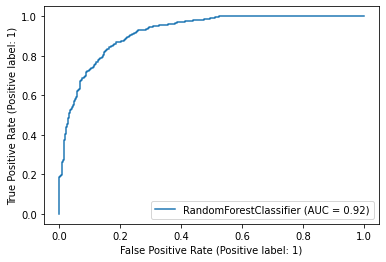

In [23]:
# Evaluating the performance using Random Forest Classifier

rfc_classifier = RFC(n_estimators = 1000, min_samples_split = 80, min_samples_leaf = 20, max_depth = 7) # Hyperparameters 
rfc_classifier.fit(X_train, y_train)                      
rfc_predictions = rfc_classifier.predict(X_validation)  
print("\n*************************************************************************************\n")

# Evaluating the performance on the test dataset
print("Accuracy obtained by Random Forest Classifier is :", accuracy(y_validation, rfc_predictions)) 
print("F1 Score obtained by Random Forest Classifier is :", f1score(y_validation, rfc_predictions)) 
print("Precision obtained by Random Forest Classifier is :", precision(y_validation, rfc_predictions))  
print("Recall obtained by Random Forest Classifier is :", recall(y_validation, rfc_predictions)) 
print("AUC score obtained by Random Forest Classifier is :", roc_auc_score(y_validation, rfc_predictions)) 
print("\n*************************************************************************************\n") 


# Calculating the Type-1 Error and Type-2 Errors
print("Type-1 Error obtained by Random Forest Classifier is :", cm(y_validation, rfc_predictions)[1][0]/(cm(y_validation, rfc_predictions)[1][0] + cm(y_validation, rfc_predictions)[1][1]))
print("Type-2 Error obtained by Random Forest Classifier is :", cm(y_validation, rfc_predictions)[0][1]/(cm(y_validation, rfc_predictions)[1][1] + cm(y_validation, rfc_predictions)[0][1]))
print("\n*************************************************************************************\n")


# Plotting ROC curve for the model
print("ROC Curve for Random Forest Classifier:\n")
plot_roc_curve(rfc_classifier, X_validation, y_validation) 
print("\n*************************************************************************************\n")

*************************************************************************************

Accuracy obtained by Linear Support Vector Classifier is : 0.8181233933161953
F1 Score obtained by Linear Support Vector Classifier is : 0.8230143839899937
Precision obtained by Linear Support Vector Classifier is : 0.8014616321559074
Recall obtained by Linear Support Vector Classifier is : 0.8457583547557841
AUC score obtained by Linear Support Vector Classifier is : 0.8181233933161953

*************************************************************************************

Type-1 Error obtained by Linear Support Vector Classifier is : 0.15424164524421594
Type-2 Error obtained by Linear Support Vector Classifier is : 0.19853836784409257

*************************************************************************************

ROC Curve for Linear Support Vector Classifier:


*************************************************************************************



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


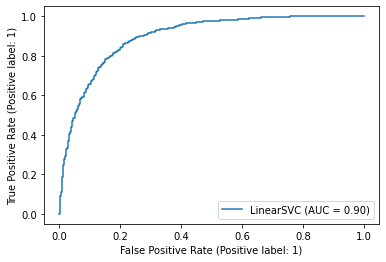

In [ ]:
# Evaluating the performance using LinearSVC Classifier

svc_classifier = SVC(tol = 1e-05, max_iter = 300, C = 0.1) # Hyperparameters 
svc_classifier.fit(X_train, y_train)                      
svc_predictions = svc_classifier.predict(X_validation)  
print("*************************************************************************************\n")

# Evaluating the performance on the test dataset
print("Accuracy obtained by Linear Support Vector Classifier is :", accuracy(y_validation, svc_predictions)) 
print("F1 Score obtained by Linear Support Vector Classifier is :", f1score(y_validation, svc_predictions)) 
print("Precision obtained by Linear Support Vector Classifier is :", precision(y_validation, svc_predictions)) 
print("Recall obtained by Linear Support Vector Classifier is :", recall(y_validation, svc_predictions)) 
print("AUC score obtained by Linear Support Vector Classifier is :", roc_auc_score(y_validation, svc_predictions))
print("\n*************************************************************************************\n")


# Calculating the Type-1 Error and Type-2 Errors
print("Type-1 Error obtained by Linear Support Vector Classifier is :", cm(y_validation, svc_predictions)[1][0] / (cm(y_validation, svc_predictions)[1][0] + cm(y_validation, svc_predictions)[1][1]))
print("Type-2 Error obtained by Linear Support Vector Classifier is :", cm(y_validation, svc_predictions)[0][1] / (cm(y_validation, svc_predictions)[0][1] + cm(y_validation, svc_predictions)[1][1]))
print("\n*************************************************************************************\n")


# Plotting ROC curve for the model
print("ROC Curve for Linear Support Vector Classifier:\n")
plot_roc_curve(svc_classifier, X_validation, y_validation) 
print("\n*************************************************************************************\n")


*************************************************************************************

Accuracy obtained by XGBoost Classifier is : 0.9447300771208226
F1 Score obtained by XGBoost Classifier is : 0.9451530612244897
Precision obtained by XGBoost Classifier is : 0.9379746835443038
Recall obtained by XGBoost Classifier is : 0.9524421593830334
AUC score obtained by XGBoost Classifier is : 0.9447300771208226

*************************************************************************************

Type-1 Error obtained by XGBoost Classifier is : 0.04755784061696658
Type-2 Error obtained by XGBoost Classifier is : 0.0620253164556962

*************************************************************************************

ROC Curve for XGBoost Classifier: 


*************************************************************************************



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


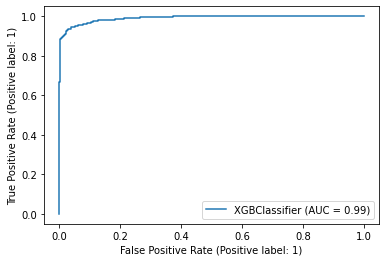

In [31]:
# Evaluating the performance using XGB Classifier

xgb_classifier = XGBC(reg_lambda = 1.0, min_child_weight = 1, max_depth = 10, learning_rate = 0.15, gamma = 0.2, colsample_bytree = 0.7) # Hyperparameters 
xgb_classifier.fit(X_train, y_train)                      
xgb_predictions = xgb_classifier.predict(X_validation)  
print("\n*************************************************************************************\n")

# Evaluating the performance on the test dataset
print("Accuracy obtained by XGBoost Classifier is :", accuracy(y_validation, xgb_predictions)) 
print("F1 Score obtained by XGBoost Classifier is :", f1score(y_validation, xgb_predictions)) 
print("Precision obtained by XGBoost Classifier is :", precision(y_validation, xgb_predictions)) 
print("Recall obtained by XGBoost Classifier is :", recall(y_validation, xgb_predictions)) 
print("AUC score obtained by XGBoost Classifier is :", roc_auc_score(y_validation, xgb_predictions))
print("\n*************************************************************************************\n")


# Calculating the Type-1 Error and Type-2 Errors
print("Type-1 Error obtained by XGBoost Classifier is :", cm(y_validation, xgb_predictions)[1][0] / (cm(y_validation, xgb_predictions)[1][0] + cm(y_validation, xgb_predictions)[1][1]))
print("Type-2 Error obtained by XGBoost Classifier is :", cm(y_validation, xgb_predictions)[0][1] / (cm(y_validation, xgb_predictions)[0][1] + cm(y_validation, xgb_predictions)[1][1]))
print("\n*************************************************************************************\n")


# Plotting ROC curve for the model
print("ROC Curve for XGBoost Classifier:", '\n')
plot_roc_curve(xgb_classifier, X_validation, y_validation) 
print("\n*************************************************************************************\n")


*************************************************************************************

Accuracy obtained by KNN Classifier is : 0.8901028277634961
F1 Score obtained by KNN Classifier is : 0.8970499698976521
Precision obtained by KNN Classifier is : 0.8437146092865232
Recall obtained by KNN Classifier is : 0.9575835475578406
AUC score obtained by KNN Classifier is : 0.890102827763496

*************************************************************************************

Type-1 Error obtained by KNN Classifier is : 0.0407911001236094
Type-2 Error obtained by KNN Classifier is : 0.1619718309859155

*************************************************************************************

ROC Curve for KNN Classifier:


*************************************************************************************



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


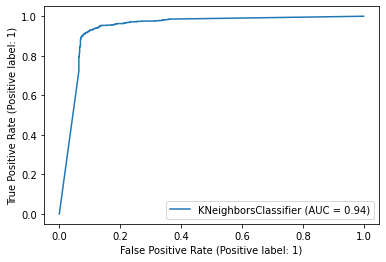

In [ ]:
# Evaluating the performance using KNN Classifier

knn_classifier = KNC(weights =  'distance', n_neighbors = 5, metric = 'minkowski') # Hyperparameters 
knn_classifier.fit(X_train, y_train)                      
knn_predictions = knn_classifier.predict(X_validation)  
print("\n*************************************************************************************\n")

# Evaluating the performance on the test dataset
print("Accuracy obtained by KNN Classifier is :", accuracy(y_validation, knn_predictions)) 
print("F1 Score obtained by KNN Classifier is :", f1score(y_validation, knn_predictions)) 
print("Precision obtained by KNN Classifier is :", precision(y_validation, knn_predictions))  
print("Recall obtained by KNN Classifier is :", recall(y_validation, knn_predictions)) 
print("AUC score obtained by KNN Classifier is :", roc_auc_score(y_validation, knn_predictions)) 
print("\n*************************************************************************************\n") 


# Calculating the Type-1 Error and Type-2 Errors
print("Type-1 Error obtained by KNN Classifier is :", cm(y_validation, knn_predictions)[1][0]/(cm(y_validation, rfc_predictions)[1][0] + cm(y_validation, knn_predictions)[1][1]))
print("Type-2 Error obtained by KNN Classifier is :", cm(y_validation, knn_predictions)[0][1]/(cm(y_validation, rfc_predictions)[1][1] + cm(y_validation, knn_predictions)[0][1]))
print("\n*************************************************************************************\n")


# Plotting ROC curve for the model
print("ROC Curve for KNN Classifier:\n")
plot_roc_curve(knn_classifier, X_validation, y_validation) 
print("\n*************************************************************************************\n")


*************************************************************************************

Accuracy obtained by MLP Classifier is : 0.8862467866323908
F1 Score obtained by MLP Classifier is : 0.8888888888888888
Precision obtained by MLP Classifier is : 0.8687116564417178
Recall obtained by MLP Classifier is : 0.910025706940874
AUC score obtained by MLP Classifier is : 0.8862467866323908

*************************************************************************************

Type-1 Error obtained by MLP Classifier is : 0.08997429305912596
Type-2 Error obtained by MLP Classifier is : 0.1312883435582822

*************************************************************************************

ROC Curve for MLP Classifier:


*************************************************************************************



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


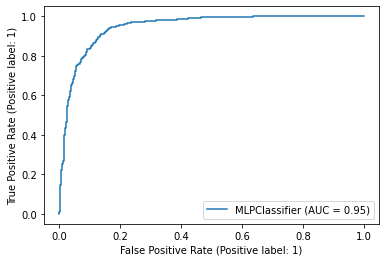

In [ ]:
# Evaluating the performance using MLP Classifier

mlp_classifier = MLPC(max_iter = 500, learning_rate_init = 0.001, hidden_layer_sizes = (128, 64, 32, 16)) # Hyperparameters 
mlp_classifier.fit(X_train, y_train)                      
mlp_predictions = mlp_classifier.predict(X_validation)  
print("\n*************************************************************************************\n")

# Evaluating the performance on the test dataset
print("Accuracy obtained by MLP Classifier is :", accuracy(y_validation, mlp_predictions)) 
print("F1 Score obtained by MLP Classifier is :", f1score(y_validation, mlp_predictions)) 
print("Precision obtained by MLP Classifier is :", precision(y_validation, mlp_predictions))  
print("Recall obtained by MLP Classifier is :", recall(y_validation, mlp_predictions)) 
print("AUC score obtained by MLP Classifier is :", roc_auc_score(y_validation, mlp_predictions)) 
print("\n*************************************************************************************\n") 


# Calculating the Type-1 Error and Type-2 Errors
print("Type-1 Error obtained by MLP Classifier is :", cm(y_validation, mlp_predictions)[1][0]/(cm(y_validation, mlp_predictions)[1][0] + cm(y_validation, mlp_predictions)[1][1]))
print("Type-2 Error obtained by MLP Classifier is :", cm(y_validation, mlp_predictions)[0][1]/(cm(y_validation, mlp_predictions)[1][1] + cm(y_validation, mlp_predictions)[0][1]))
print("\n*************************************************************************************\n")


# Plotting ROC curve for the model
print("ROC Curve for MLP Classifier:\n")
plot_roc_curve(mlp_classifier, X_validation, y_validation) 
print("\n*************************************************************************************\n")

## **Making Predictions on Unseen Data**

In [25]:
# Using Min-Max Scaler to scale the data
scaler = MMS()
X_test['bmi'] = scaler.fit_transform(pd.DataFrame(X_test['bmi']))
X_test['avg_glucose_level'] = scaler.fit_transform(pd.DataFrame(X_test['avg_glucose_level']))
X_test['age'] = scaler.fit_transform(pd.DataFrame(X_test['age']))


*************************************************************************************

Accuracy obtained by Random Forest Classifier is : 0.8329048843187661
F1 Score obtained by Random Forest Classifier is : 0.8388696083292019
Precision obtained by Random Forest Classifier is : 0.8095693779904306
Recall obtained by Random Forest Classifier is : 0.8703703703703703
AUC score obtained by Random Forest Classifier is : 0.8329241368809713

*************************************************************************************

Type-1 Error obtained by Random Forest Classifier is : 0.12962962962962962
Type-2 Error obtained by Random Forest Classifier is : 0.19043062200956937

*************************************************************************************

ROC Curve for Random Forest Classifier:



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)



*************************************************************************************



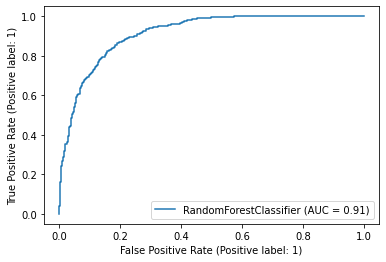

In [26]:
rfc_test_predictions = rfc_classifier.predict(X_test)  

print("\n*************************************************************************************\n")

# Evaluating the performance on the test dataset
print("Accuracy obtained by Random Forest Classifier is :", accuracy(y_test, rfc_test_predictions)) 
print("F1 Score obtained by Random Forest Classifier is :", f1score(y_test, rfc_test_predictions)) 
print("Precision obtained by Random Forest Classifier is :", precision(y_test, rfc_test_predictions))  
print("Recall obtained by Random Forest Classifier is :", recall(y_test, rfc_test_predictions)) 
print("AUC score obtained by Random Forest Classifier is :", roc_auc_score(y_test, rfc_test_predictions)) 
print("\n*************************************************************************************\n") 


# Calculating the Type-1 Error and Type-2 Errors
print("Type-1 Error obtained by Random Forest Classifier is :", cm(y_test, rfc_test_predictions)[1][0]/(cm(y_test, rfc_test_predictions)[1][0] + cm(y_test, rfc_test_predictions)[1][1]))
print("Type-2 Error obtained by Random Forest Classifier is :", cm(y_test, rfc_test_predictions)[0][1]/(cm(y_test, rfc_test_predictions)[1][1] + cm(y_test, rfc_test_predictions)[0][1]))
print("\n*************************************************************************************\n")


# Plotting ROC curve for the model
print("ROC Curve for Random Forest Classifier:\n")
plot_roc_curve(rfc_classifier, X_test, y_test) 
print("\n*************************************************************************************\n")

*************************************************************************************

Accuracy obtained by Linear Support Vector Classifier is : 0.8004115226337448
F1 Score obtained by Linear Support Vector Classifier is : 0.8081107814045501
Precision obtained by Linear Support Vector Classifier is : 0.7780952380952381
Recall obtained by Linear Support Vector Classifier is : 0.8405349794238683
AUC score obtained by Linear Support Vector Classifier is : 0.8004115226337449

*************************************************************************************

Type-1 Error obtained by Linear Support Vector Classifier is : 0.15946502057613168
Type-2 Error obtained by Linear Support Vector Classifier is : 0.2219047619047619

*************************************************************************************

ROC Curve for Linear Support Vector Classifier:


*************************************************************************************



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


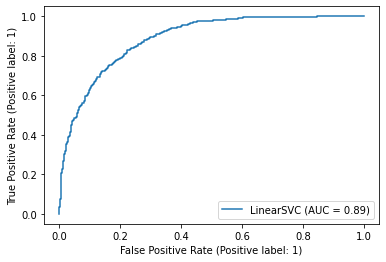

In [ ]:
svc_test_predictions = svc_classifier.predict(X_test)  
print("*************************************************************************************\n")

# Evaluating the performance on the test dataset
print("Accuracy obtained by Linear Support Vector Classifier is :", accuracy(y_test, svc_test_predictions)) 
print("F1 Score obtained by Linear Support Vector Classifier is :", f1score(y_test, svc_test_predictions)) 
print("Precision obtained by Linear Support Vector Classifier is :", precision(y_test, svc_test_predictions)) 
print("Recall obtained by Linear Support Vector Classifier is :", recall(y_test, svc_test_predictions)) 
print("AUC score obtained by Linear Support Vector Classifier is :", roc_auc_score(y_test, svc_test_predictions))
print("\n*************************************************************************************\n")


# Calculating the Type-1 Error and Type-2 Errors
print("Type-1 Error obtained by Linear Support Vector Classifier is :", cm(y_test, svc_test_predictions)[1][0] / (cm(y_test, svc_test_predictions)[1][0] + cm(y_test, svc_test_predictions)[1][1]))
print("Type-2 Error obtained by Linear Support Vector Classifier is :", cm(y_test, svc_test_predictions)[0][1] / (cm(y_test, svc_test_predictions)[0][1] + cm(y_test, svc_test_predictions)[1][1]))
print("\n*************************************************************************************\n")


# Plotting ROC curve for the model
print("ROC Curve for Linear Support Vector Classifier:\n")
plot_roc_curve(svc_classifier, X_test, y_test) 
print("\n*************************************************************************************\n")


*************************************************************************************

Accuracy obtained by XGBoost Classifier is : 0.8801440329218106
F1 Score obtained by XGBoost Classifier is : 0.8679886685552409
Precision obtained by XGBoost Classifier is : 0.9659520807061791
Recall obtained by XGBoost Classifier is : 0.7880658436213992
AUC score obtained by XGBoost Classifier is : 0.8801440329218108

*************************************************************************************

Type-1 Error obtained by XGBoost Classifier is : 0.21193415637860083
Type-2 Error obtained by XGBoost Classifier is : 0.034047919293820936

*************************************************************************************

ROC Curve for XGBoost Classifier: 


*************************************************************************************



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


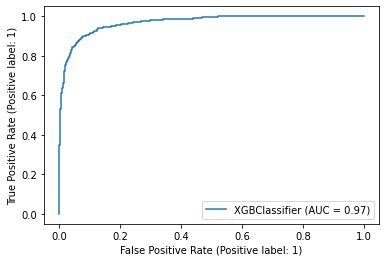

In [ ]:
xgb_test_predictions = xgb_classifier.predict(X_test)  
print("\n*************************************************************************************\n")

# Evaluating the performance on the test dataset
print("Accuracy obtained by XGBoost Classifier is :", accuracy(y_test, xgb_test_predictions)) 
print("F1 Score obtained by XGBoost Classifier is :", f1score(y_test, xgb_test_predictions)) 
print("Precision obtained by XGBoost Classifier is :", precision(y_test, xgb_test_predictions)) 
print("Recall obtained by XGBoost Classifier is :", recall(y_test, xgb_test_predictions)) 
print("AUC score obtained by XGBoost Classifier is :", roc_auc_score(y_test, xgb_test_predictions))
print("\n*************************************************************************************\n")


# Calculating the Type-1 Error and Type-2 Errors
print("Type-1 Error obtained by XGBoost Classifier is :", cm(y_test, xgb_test_predictions)[1][0] / (cm(y_test, xgb_test_predictions)[1][0] + cm(y_test, xgb_test_predictions)[1][1]))
print("Type-2 Error obtained by XGBoost Classifier is :", cm(y_test, xgb_test_predictions)[0][1] / (cm(y_test, xgb_test_predictions)[0][1] + cm(y_test, xgb_test_predictions)[1][1]))
print("\n*************************************************************************************\n")


# Plotting ROC curve for the model
print("ROC Curve for XGBoost Classifier:", '\n')
plot_roc_curve(xgb_classifier, X_test, y_test) 
print("\n*************************************************************************************\n")


*************************************************************************************

Accuracy obtained by KNN Classifier is : 0.8132716049382716
F1 Score obtained by KNN Classifier is : 0.8125967991739803
Precision obtained by KNN Classifier is : 0.8155440414507772
Recall obtained by KNN Classifier is : 0.8096707818930041
AUC score obtained by KNN Classifier is : 0.8132716049382717

*************************************************************************************

Type-1 Error obtained by KNN Classifier is : 0.19032921810699588
Type-2 Error obtained by KNN Classifier is : 0.1844559585492228

*************************************************************************************

ROC Curve for KNN Classifier:


*************************************************************************************



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


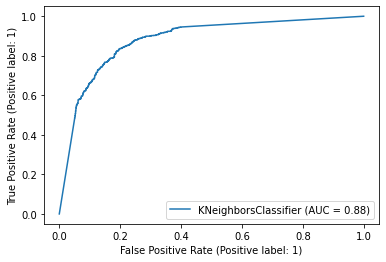

In [ ]:
knn_test_predictions = knn_classifier.predict(X_test)  
print("\n*************************************************************************************\n")

# Evaluating the performance on the test dataset
print("Accuracy obtained by KNN Classifier is :", accuracy(y_test, knn_test_predictions)) 
print("F1 Score obtained by KNN Classifier is :", f1score(y_test, knn_test_predictions)) 
print("Precision obtained by KNN Classifier is :", precision(y_test, knn_test_predictions))  
print("Recall obtained by KNN Classifier is :", recall(y_test, knn_test_predictions)) 
print("AUC score obtained by KNN Classifier is :", roc_auc_score(y_test, knn_test_predictions)) 
print("\n*************************************************************************************\n") 


# Calculating the Type-1 Error and Type-2 Errors
print("Type-1 Error obtained by KNN Classifier is :", cm(y_test, knn_test_predictions)[1][0]/(cm(y_test, knn_test_predictions)[1][0] + cm(y_test, knn_test_predictions)[1][1]))
print("Type-2 Error obtained by KNN Classifier is :", cm(y_test, knn_test_predictions)[0][1]/(cm(y_test, knn_test_predictions)[1][1] + cm(y_test, knn_test_predictions)[0][1]))
print("\n*************************************************************************************\n")


# Plotting ROC curve for the model
print("ROC Curve for KNN Classifier:\n")
plot_roc_curve(knn_classifier, X_test, y_test) 
print("\n*************************************************************************************\n")


*************************************************************************************

Accuracy obtained by MLP Classifier is : 0.7752057613168725
F1 Score obtained by MLP Classifier is : 0.7418783225044299
Precision obtained by MLP Classifier is : 0.871012482662968
Recall obtained by MLP Classifier is : 0.6460905349794238
AUC score obtained by MLP Classifier is : 0.7752057613168725

*************************************************************************************

Type-1 Error obtained by MLP Classifier is : 0.35390946502057613
Type-2 Error obtained by MLP Classifier is : 0.1289875173370319

*************************************************************************************

ROC Curve for MLP Classifier:


*************************************************************************************



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


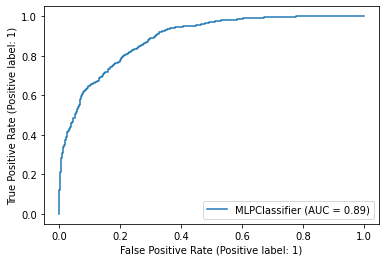

In [ ]:
mlp_test_predictions = mlp_classifier.predict(X_test)  
print("\n*************************************************************************************\n")

# Evaluating the performance on the test dataset
print("Accuracy obtained by MLP Classifier is :", accuracy(y_test, mlp_test_predictions)) 
print("F1 Score obtained by MLP Classifier is :", f1score(y_test, mlp_test_predictions)) 
print("Precision obtained by MLP Classifier is :", precision(y_test, mlp_test_predictions))  
print("Recall obtained by MLP Classifier is :", recall(y_test, mlp_test_predictions)) 
print("AUC score obtained by MLP Classifier is :", roc_auc_score(y_test, mlp_test_predictions)) 
print("\n*************************************************************************************\n") 


# Calculating the Type-1 Error and Type-2 Errors
print("Type-1 Error obtained by MLP Classifier is :", cm(y_test, mlp_test_predictions)[1][0]/(cm(y_test, mlp_test_predictions)[1][0] + cm(y_test, mlp_test_predictions)[1][1]))
print("Type-2 Error obtained by MLP Classifier is :", cm(y_test, mlp_test_predictions)[0][1]/(cm(y_test, mlp_test_predictions)[1][1] + cm(y_test, mlp_test_predictions)[0][1]))
print("\n*************************************************************************************\n")


# Plotting ROC curve for the model
print("ROC Curve for MLP Classifier:\n")
plot_roc_curve(mlp_classifier, X_test, y_test) 
print("\n*************************************************************************************\n")

## **Comparision of ROC scores and Type 2 errors**


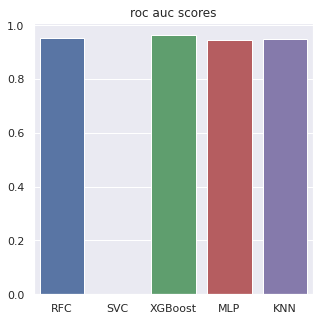

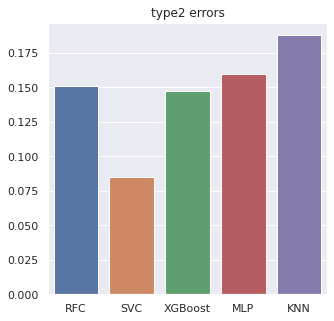

In [ ]:
models = ['RFC','SVC','XGBoost','MLP','KNN']
roc_auc_scores = [0.9524490959485625,0,0.96053089618603,0.9422828686533407,0.947324820629195]
type2_errors = [0.15044814340588988,0.0851528384279476,0.14702233250620347,0.15958102279728897,0.1873508353221957]
plt.figure(figsize=(5,5))
sns.set(rc={'figure.figsize':(11,4)})  
sns.barplot(x=models, y=roc_auc_scores)
plt.title("roc auc scores")
plt.show()
plt.figure(figsize=(5,5))

sns.barplot(x=models, y=type2_errors)
plt.title("type2 errors")
plt.show()

## **Deploying the model using Flask and Pickle**

In [27]:
# Pickle library for integration with frontend
import pickle

In [32]:
# Saving the models 
saved_data = {"model":xgb_classifier}
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(saved_data, file)

In [33]:
# Loading the models
with open('saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)


In [34]:
# Save the pkl file
from google.colab import files
files.download('saved_steps.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>